In [35]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import src.segment as segment
import src.fit as fit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')

In [36]:
import tsfresh

# Paramter

In [37]:
RELOAD_DATA = True
DATA_PATH = "data/"

## Draw

In [38]:
def draw_plot(data,plot_title):
    plot(range(len(data)),data,alpha=0.8,color='red')
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)

def draw_xvline(segments):
    for seg in segments:
        x0 = seg[0]
        plt.axvline(x=x0)
        
def draw_approximate_line(ax_set):
    fig, axs = plt.subplots(1,1, figsize=(25, 5))
    x0,y0,x1,y1 = ax_set[0]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for ax in ax_set:
        axs.plot((x1,ax[0]),(y1,ax[1]),ls='--',color='black',alpha=0.5)
        x0,y0,x1,y1 = ax
        axs.plot((x0,x1),(y0,y1),alpha=1,color=random.choice(colors))
    plt.show();

## Metrics

In [39]:
def get_anomaly_segment(line_segments):
    distance = [line_segments[0][3] - line_segments[1][1]]
    for i in range(1,len(line_segments)-1):
        left_distance = line_segments[i][1] - line_segments[i-1][3]
        right_distance = line_segments[i][3] - line_segments[i+1][1]
        dis = abs(left_distance + right_distance)
        distance.append(dis)
    last_dis = line_segments[len(line_segments)-1][1] - line_segments[len(line_segments)-2][3]
    distance.append(last_dis)
    return line_segments[distance.index(max(distance))]
def metrics(data,attack_indx,anomaly_segment):
    predict_index = np.arange(anomaly_segment[0],anomaly_segment[2],1)
    
    attack = np.zeros(data.shape[0])
    pred = np.zeros(data.shape[0])
    attack[attack_indx] = 1
    pred[predict_index] = 1
    
    tp = sum((a == 1 and p == 1) for a, p in zip(attack, pred))
    fp = sum((a == 0 and p == 1) for a, p in zip(attack, pred))
    fn = sum((a == 1 and p == 0) for a, p in zip(attack, pred))
    tn = sum((a == 0 and p == 0) for a, p in zip(attack, pred))
    
    accuracy = (tp + tn) / len(attack)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy,precision,recall,f1

# Data

In [40]:
SWaT_2019_df = pd.read_pickle(DATA_PATH + "swat_2019_attack_df.pkl")

In [41]:
SWaT_2019_df

,FIT 401,LIT 301,P601 Status,MV201,P101 Status,MV 501,P301 Status,Timestamps,label_FIT 401,label_LIT 301,label_P601 Status,label_MV201,label_P101 Status,label_MV 501,label_P301 Status
0,0.781740,730.702100,1,2,2,2,1,2019-07-20 04:30:00.000000000,0,0,0,0,0,0,0
1,0.782380,730.902344,1,2,2,2,1,2019-07-20 04:30:01.000000000,0,0,0,0,0,0,0
2,0.783021,732.344300,1,2,2,2,1,2019-07-20 04:30:02.004013000,0,0,0,0,0,0,0
3,0.783021,732.704800,1,2,2,2,1,2019-07-20 04:30:03.004013000,0,0,0,0,0,0,0
4,0.781228,732.744800,1,2,2,2,1,2019-07-20 04:30:04.000000000,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14991,0.809271,883.227051,1,2,2,2,2,2019-07-20 08:39:55.001007000,0,0,0,0,0,0,0
14992,0.809271,883.227051,1,2,2,2,2,2019-07-20 08:39:56.005004800,0,0,0,0,0,0,0
14993,0.809271,883.387268,1,2,2,2,2,2019-07-20 08:39:57.005004800,0,0,0,0,0,0,0
14994,0.808631,883.908000,1,2,2,2,2,2019-07-20 08:39:58.005004800,0,0,0,0,0,0,0


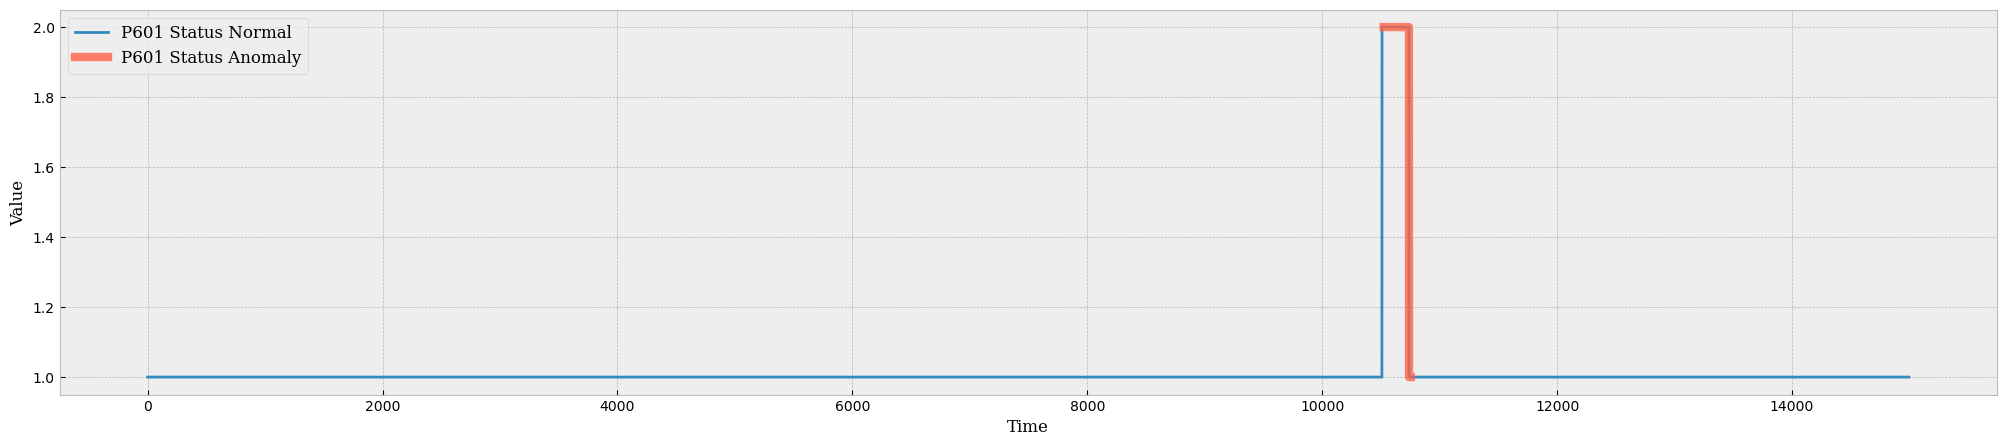

In [42]:
anomaly_feature = 'P601 Status'
anomaly_time = [np.array('2019-07-20 07:25:27', dtype=np.datetime64),
                np.array('2019-07-20 07:29:18', dtype=np.datetime64)]

with plt.style.context('bmh'):
    font = {'size': 12, 'family': 'serif'}
    font_legend = {'size': 12, 'family': 'serif'}
    fig, axs = plt.subplots(1, 1, figsize=(25,5))
    
    start_attack_time = anomaly_time[0]
    end_attack_time = anomaly_time[1]
    attack_df = SWaT_2019_df[SWaT_2019_df["Timestamps"] >= start_attack_time]
    attack_df = attack_df[attack_df["Timestamps"] <= end_attack_time]
    attack_indx =list(attack_df.index)


    axs.plot(SWaT_2019_df[anomaly_feature],
             label='{} Normal'.format(anomaly_feature))
             
    axs.plot(SWaT_2019_df[anomaly_feature].loc[attack_indx],
             label='{} Anomaly'.format(anomaly_feature),
             color='tomato', 
             linewidth=6,
             alpha=0.8)
    axs.set_xlabel('Time', fontdict=font)
    axs.set_ylabel('Value', fontdict=font)
    axs.legend(loc='upper left', prop=font_legend)
    plt.show();

## Extract Features

In [43]:
ts = pd.DataFrame(SWaT_2019_df,columns=[anomaly_feature,'Timestamps'])
ts['id'] = 1

In [44]:
extracted_feature = tsfresh.extract_features(ts,column_id='id',column_sort='Timestamps',column_value=anomaly_feature)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████| 1/1 [01:55<00:00, 115.54s/it]


In [45]:
extracted_relevant_feature = pd.DataFrame(extracted_feature,columns=[f'{anomaly_feature}__mean',
                                                                     f'{anomaly_feature}__median',
                                                                     f'{anomaly_feature}__variance',
                                                                     f'{anomaly_feature}__standard_deviation',
                                                                     f'{anomaly_feature}__mean_change',
                                                                     f'{anomaly_feature}__kurtosis',
                                                                     f'{anomaly_feature}__minimum',
                                                                     f'{anomaly_feature}__maximum']).T
extracted_relevant_feature = extracted_relevant_feature.rename(columns={1: anomaly_feature})
extracted_relevant_feature.index = ['mean','median','variance','standard_deviation','mean_change',
                                      'kurtosis','minimum','maximum']

In [46]:
extracted_relevant_feature

,P601 Status
mean,1.015337
median,1.000000
variance,0.015102
standard_deviation,0.122891
mean_change,0.000000
kurtosis,60.236059
minimum,1.000000
maximum,2.000000


👉 Data có variance **thấp**

👉 kurtosis >> 3, mean_change << phân bố dữ liệu tập trung tại 1 điểm

# Top-down

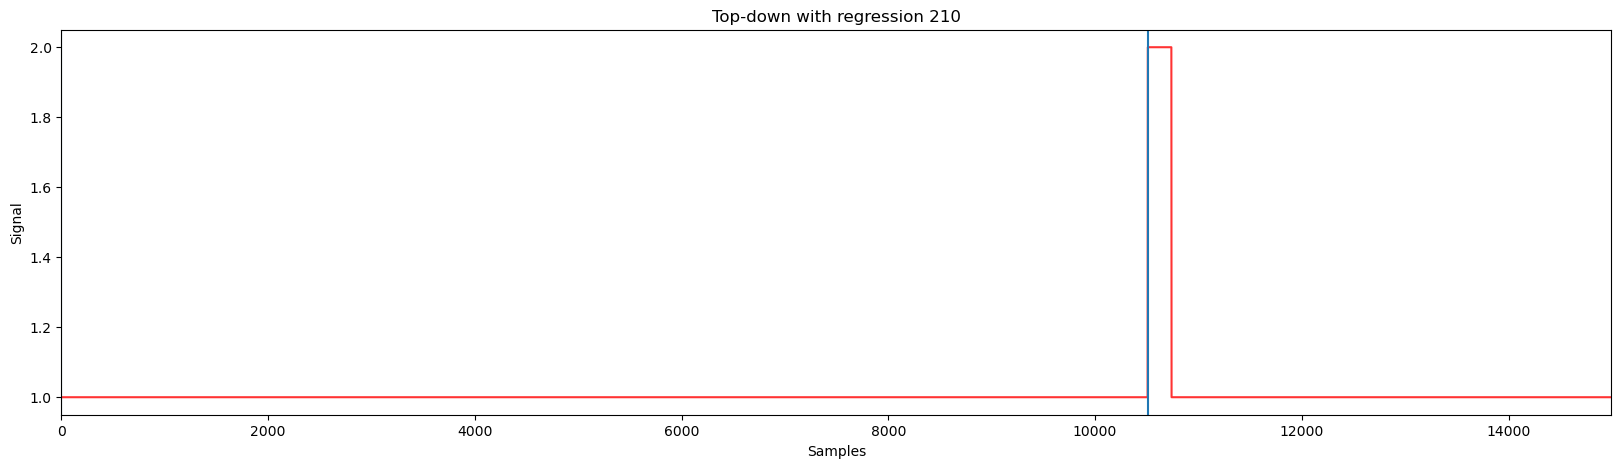

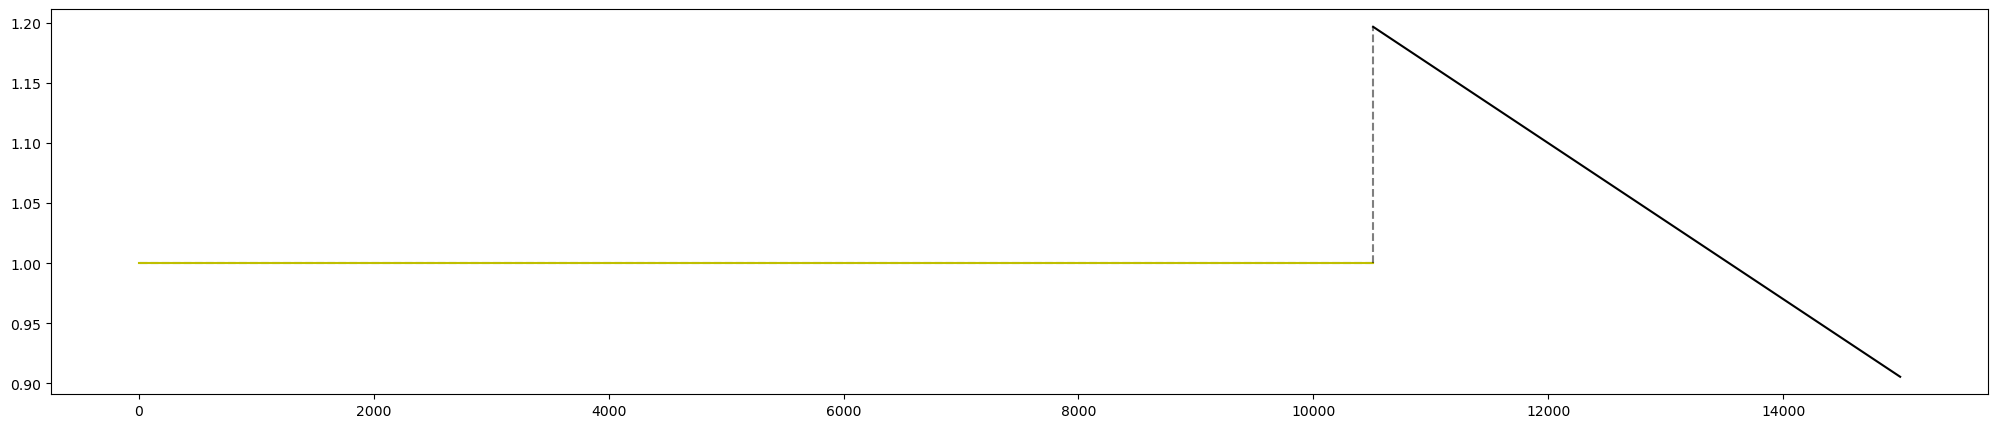

(0.71619098426247, 0.0514820592823713, 1.0, 0.09792284866468844)

In [23]:
max_error = 210
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_topdown,pre_topdown,recall_topdown,f1_topdown

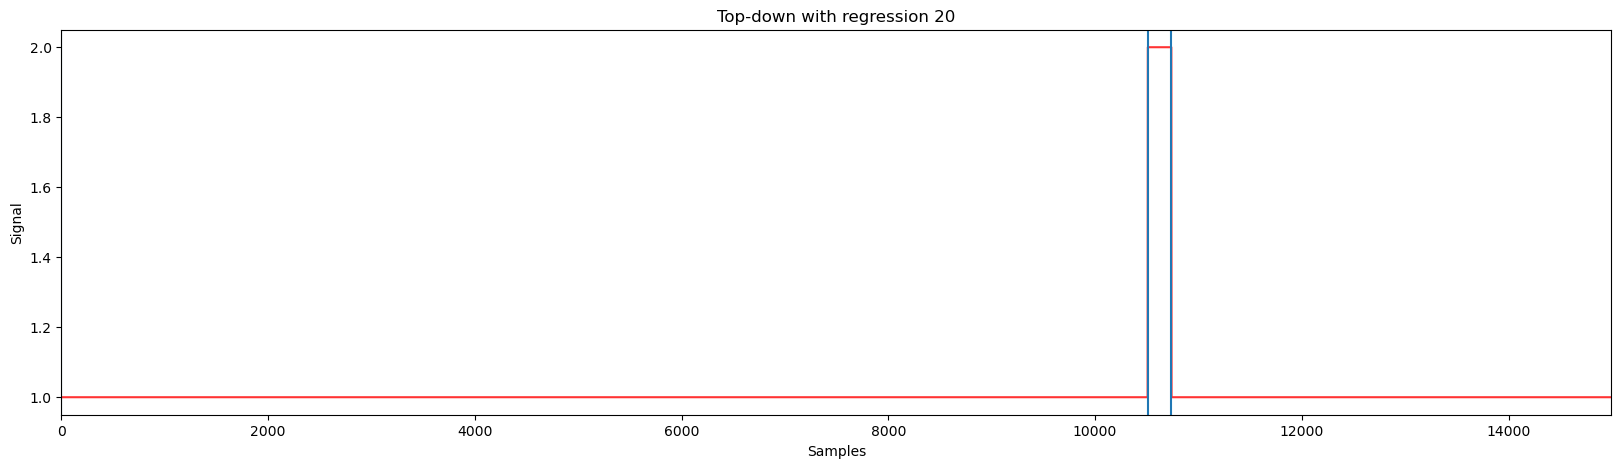

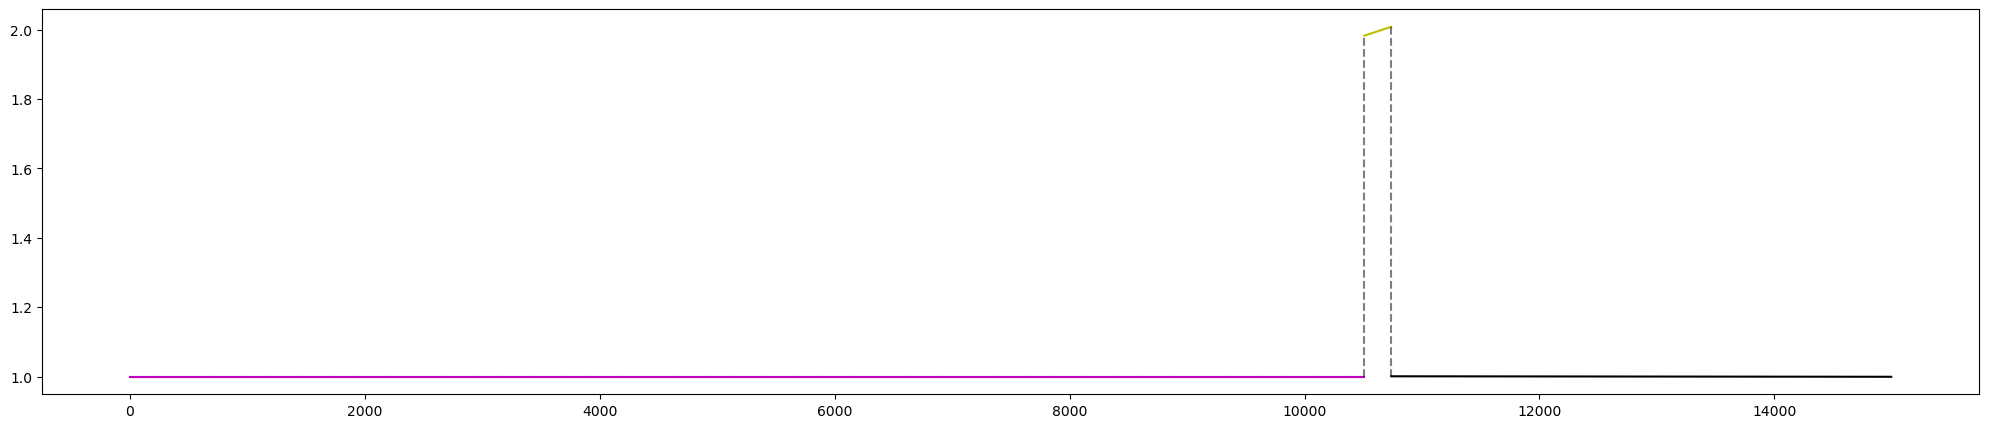

(0.9979327820752201,
 0.9347826086956522,
 0.9307359307359307,
 0.9327548806941431)

In [22]:
max_error = 20
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_topdown,pre_topdown,recall_topdown,f1_topdown

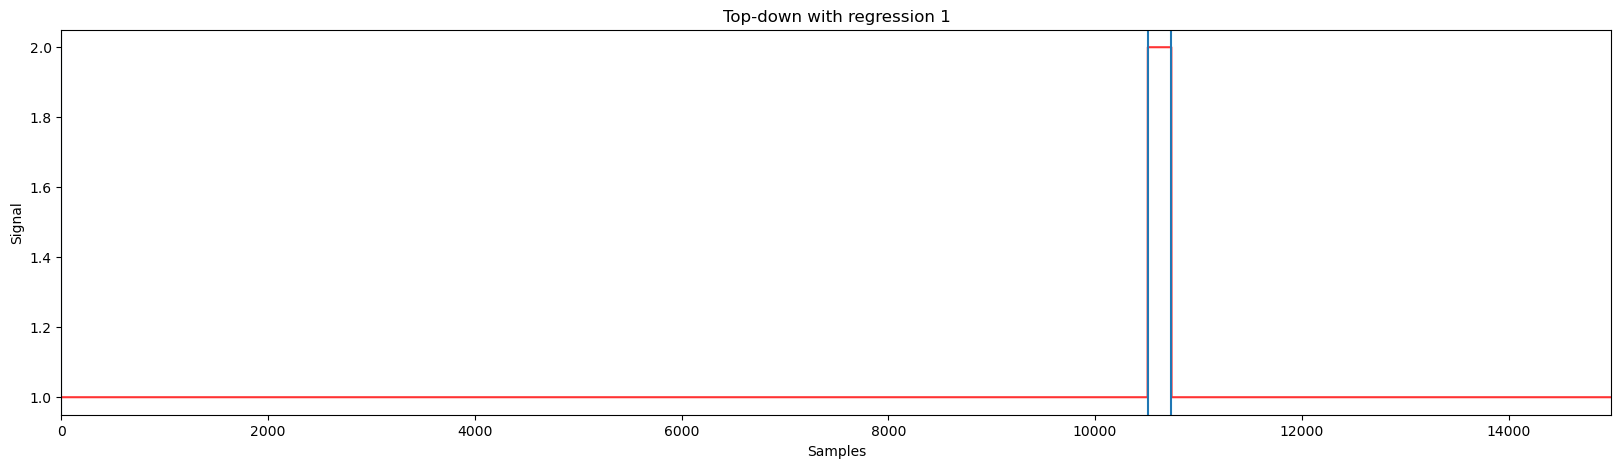

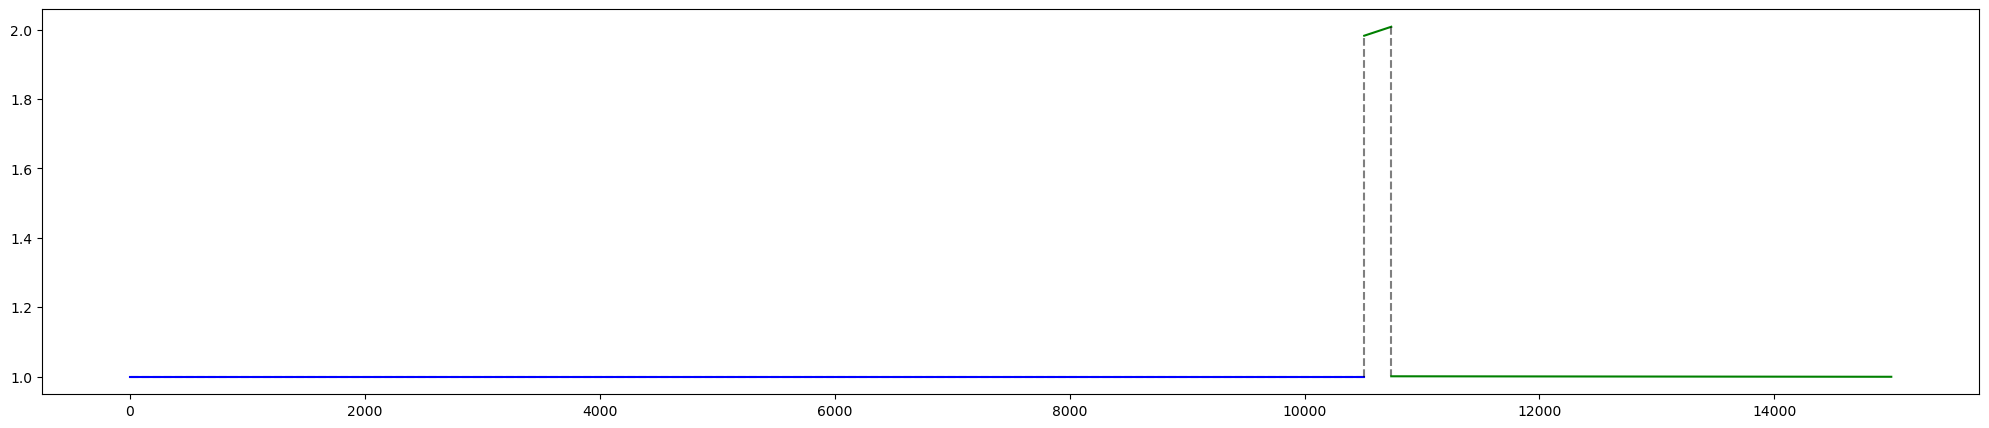

(0.9979327820752201,
 0.9347826086956522,
 0.9307359307359307,
 0.9327548806941431)

In [24]:
max_error = 1
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_topdown,pre_topdown,recall_topdown,f1_topdown

# Bottom-up

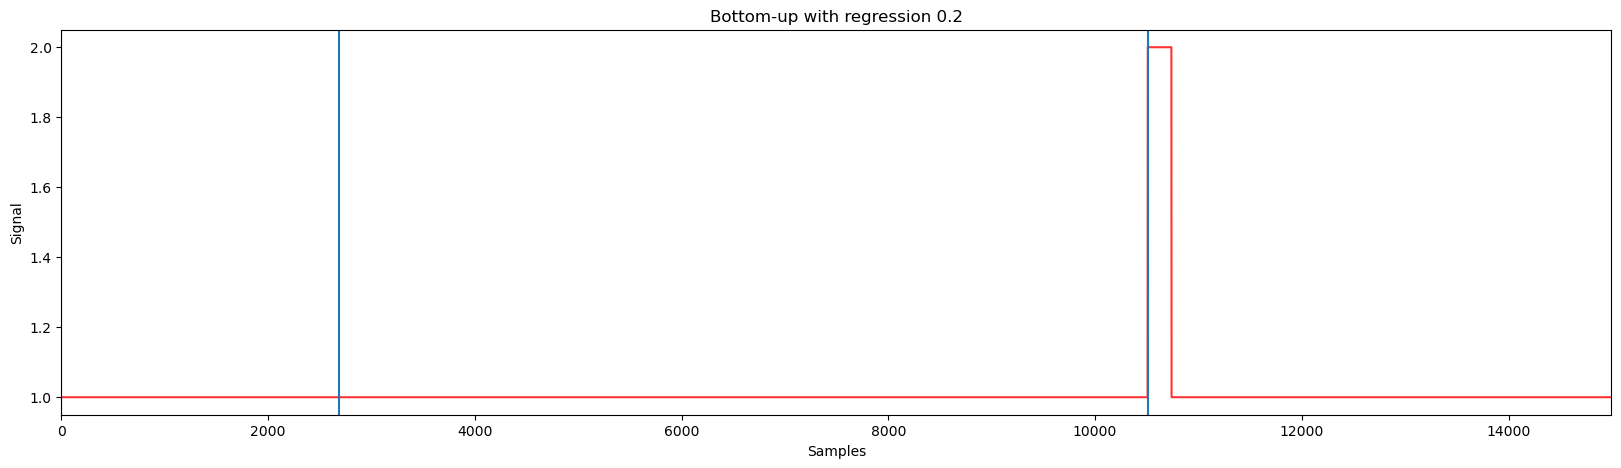

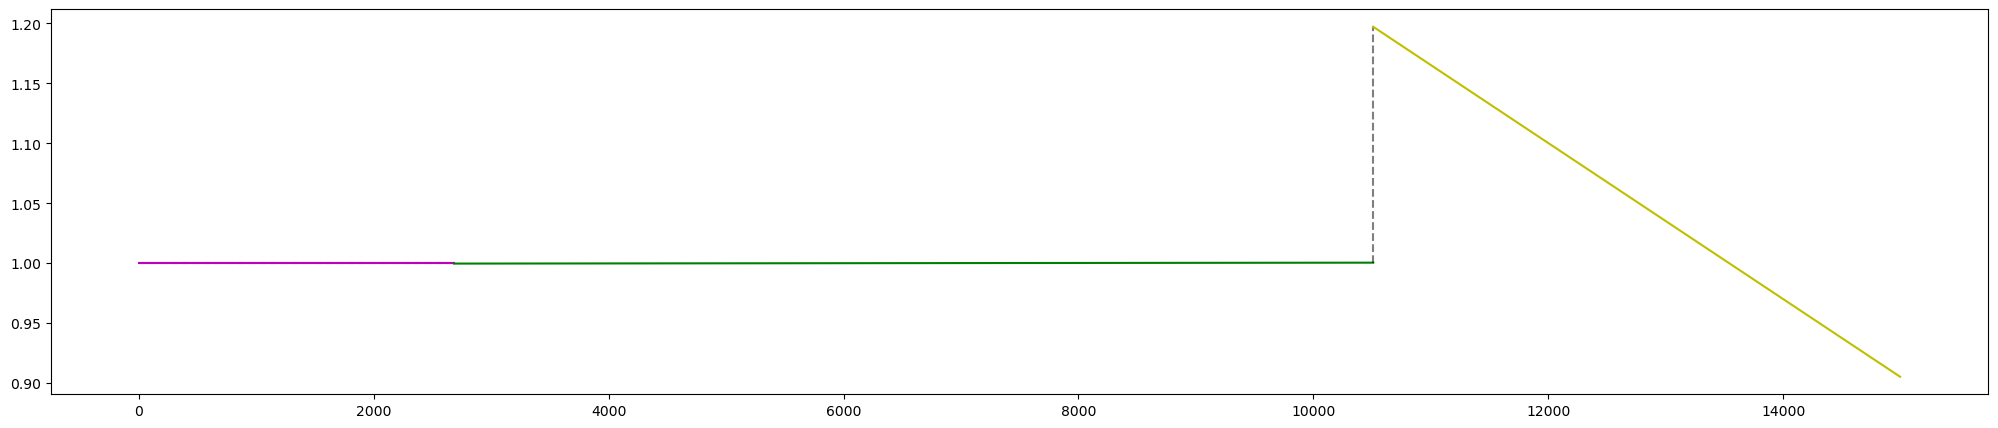

(0.4627233929047746, 0.0, 0.0, 0)

In [50]:
max_error = 0.99
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,"Bottom-up with regression 0.2")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_btu,pre_btu,recall_btu,f1_btu

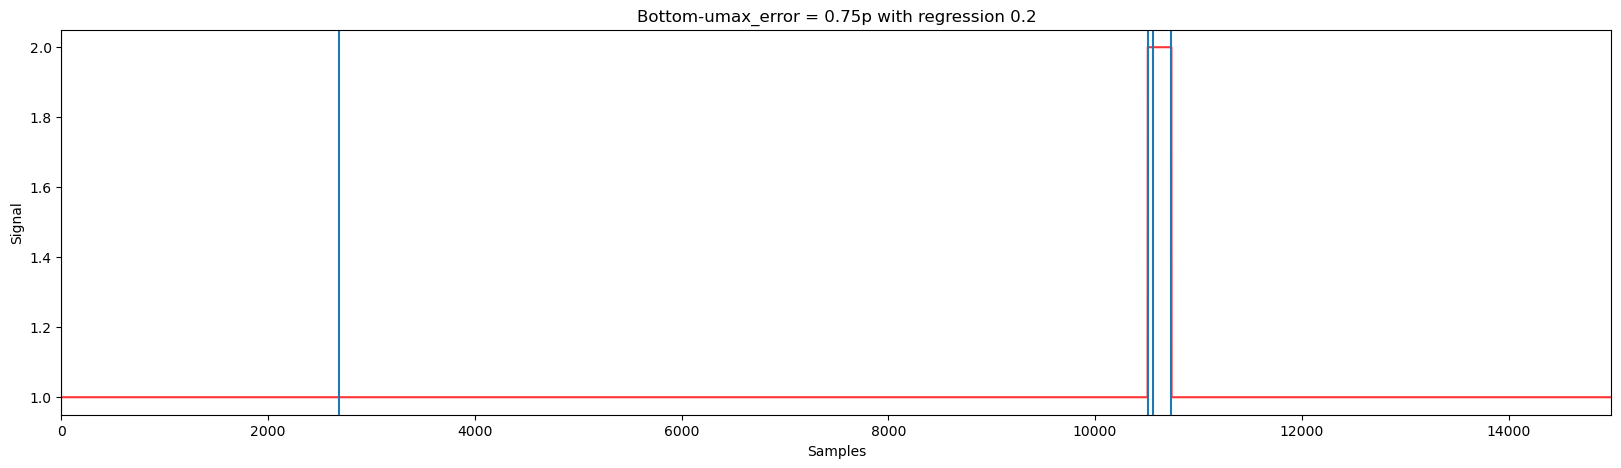

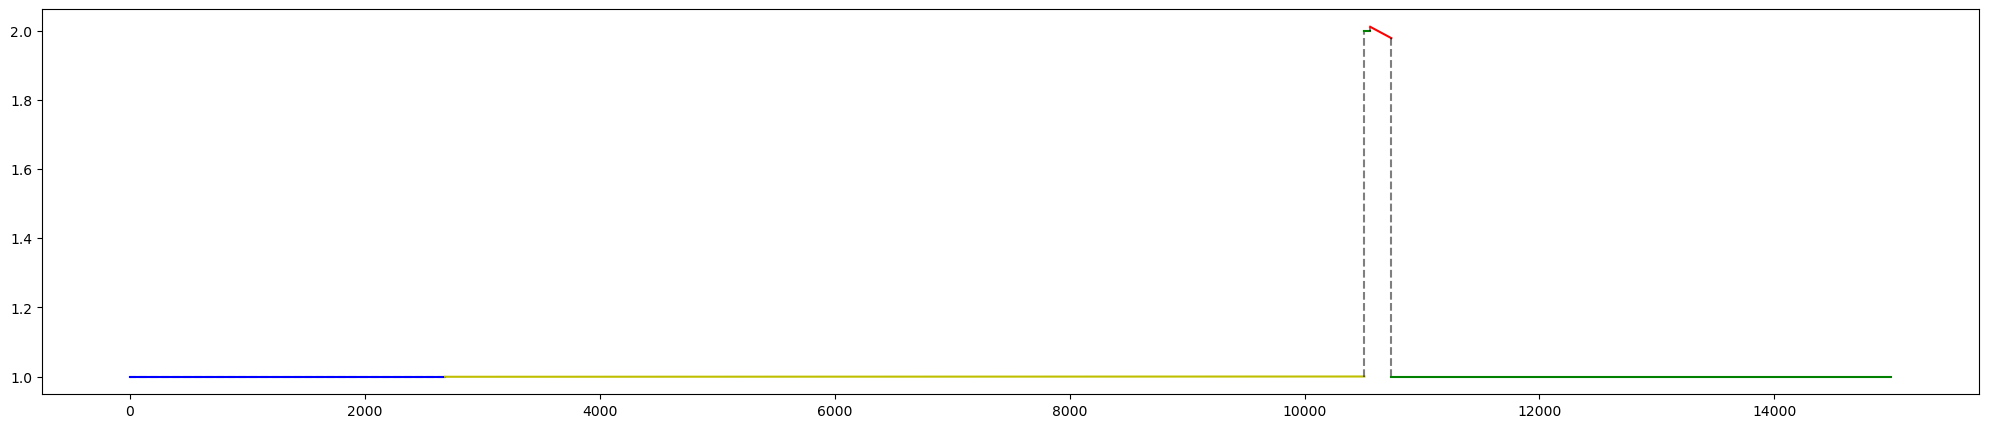

(0.4627233929047746, 0.0, 0.0, 0)

In [66]:
max_error = 0.95
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,"Bottom-umax_error = 0.75p with regression 0.2")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_btu,pre_btu,recall_btu,f1_btu

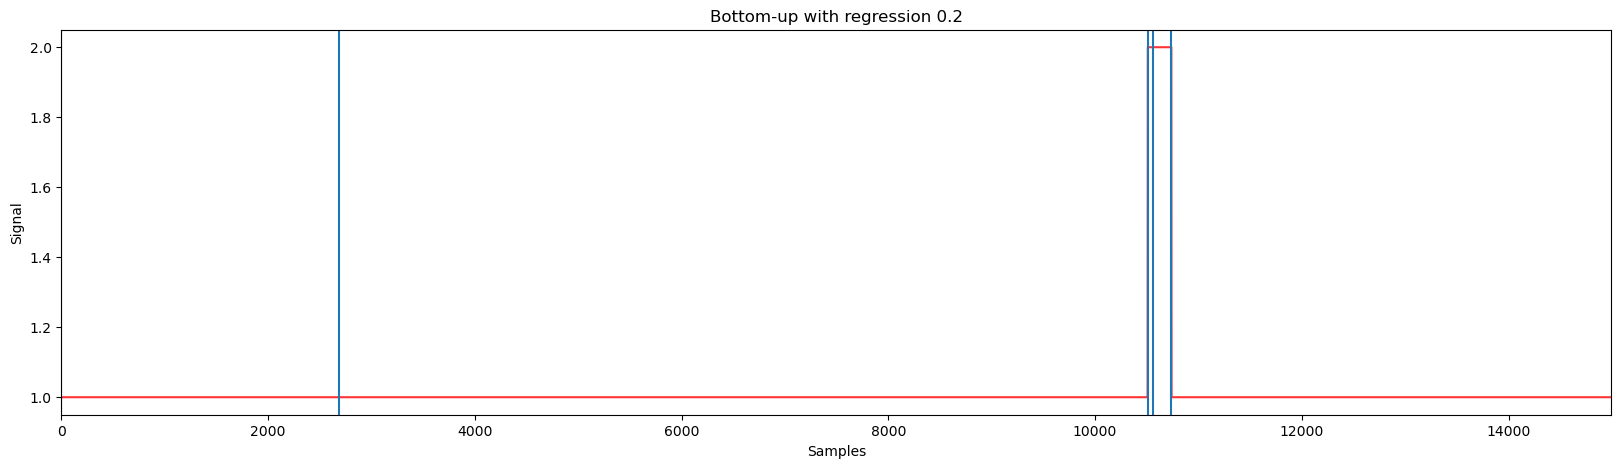

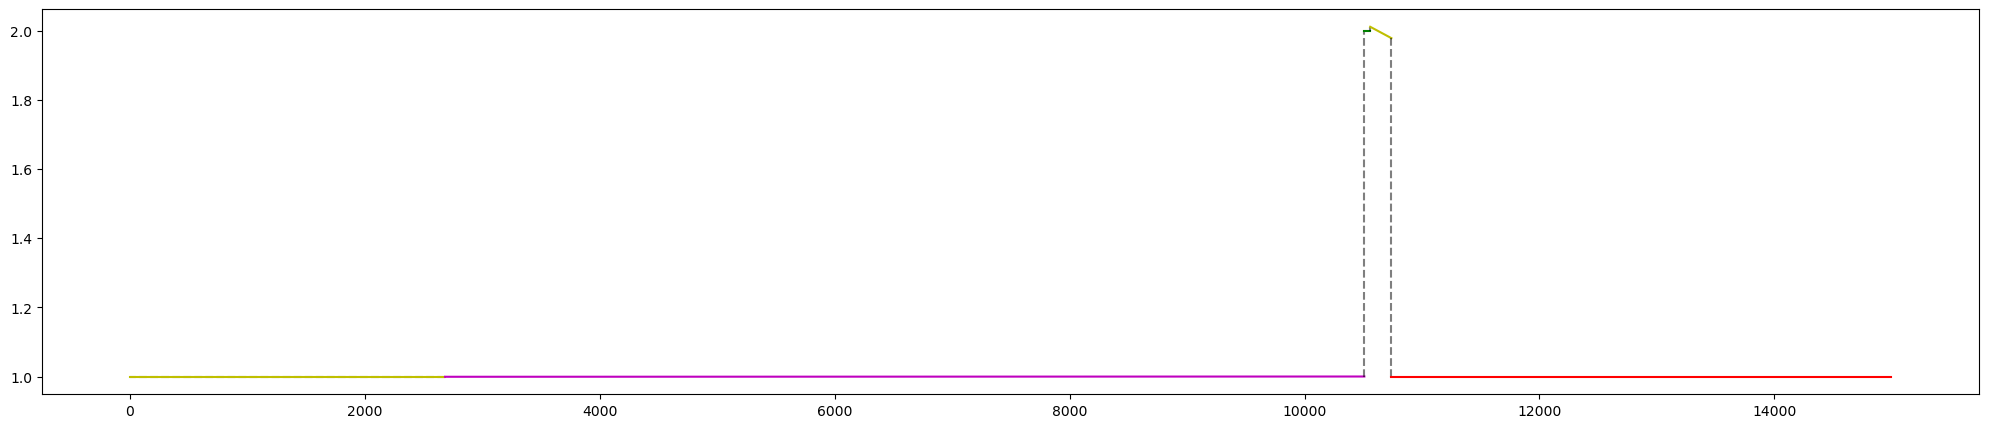

(0.4627233929047746, 0.0, 0.0, 0)

In [51]:
max_error = 0.01
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,"Bottom-up with regression 0.2")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_btu,pre_btu,recall_btu,f1_btu

# Sliding Window

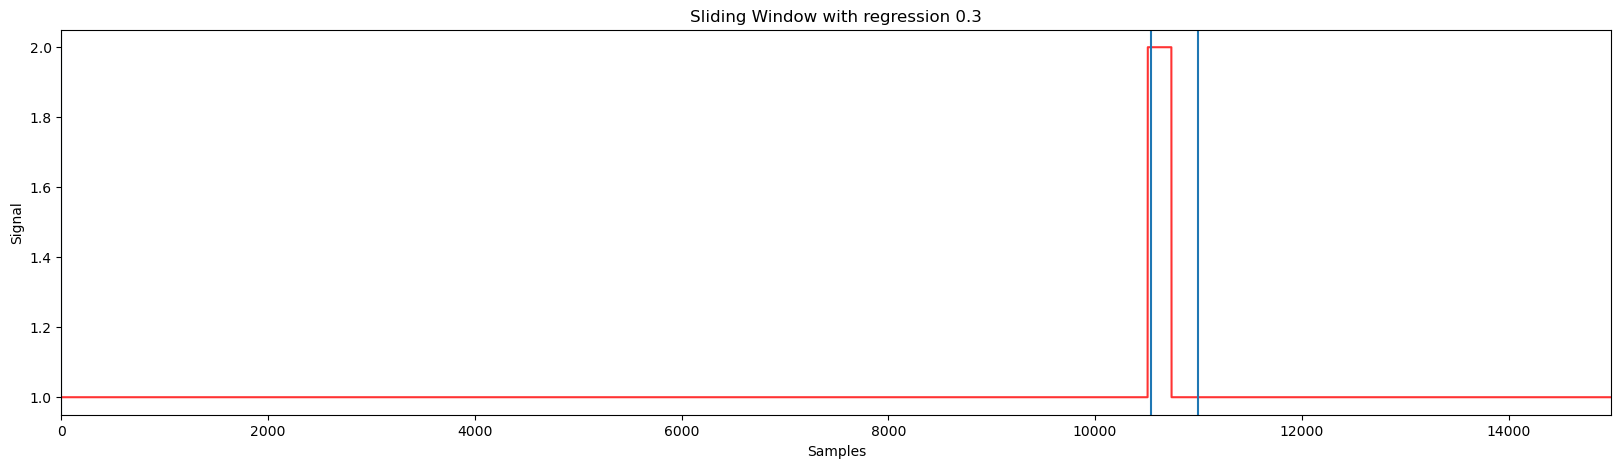

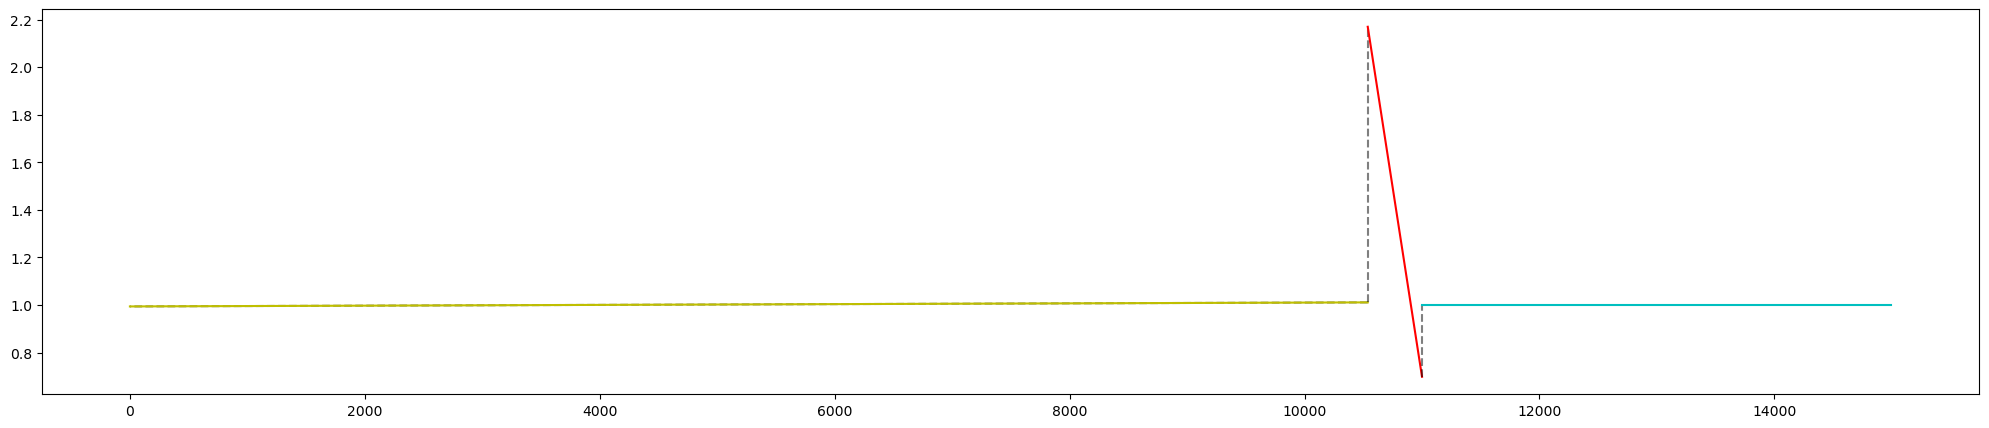

(0.9825953587623366, 0.4675324675324675, 0.935064935064935, 0.6233766233766234)

In [60]:
max_error = 30
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,"Sliding Window with regression 0.3")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_sldw,pre_sldw,recall_sldw,f1_sldw

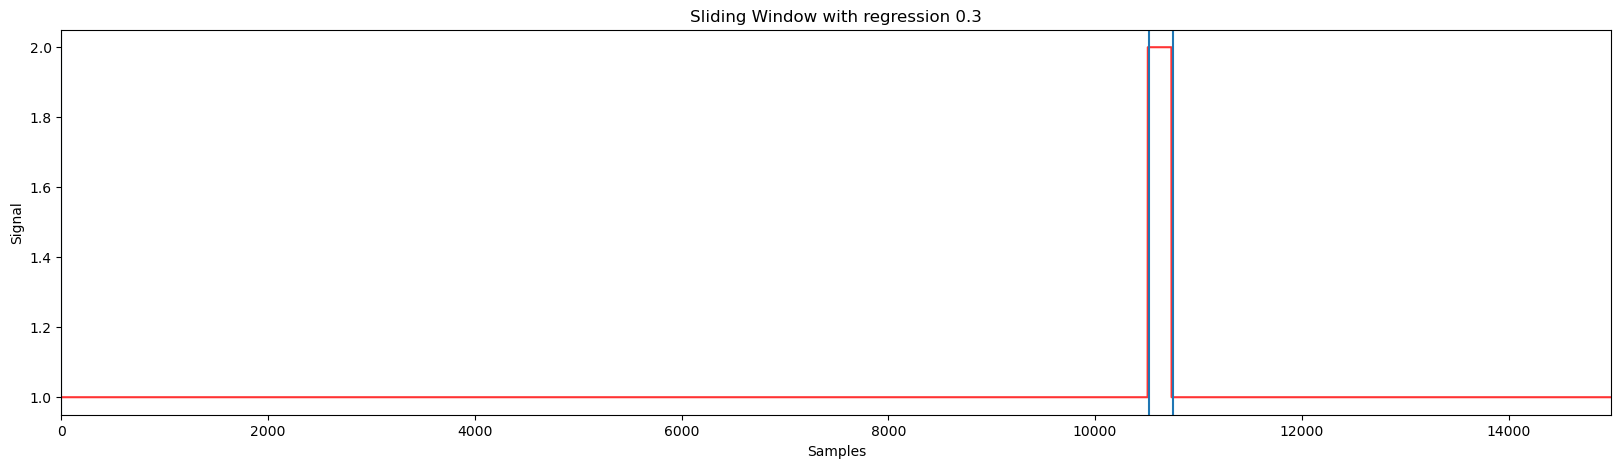

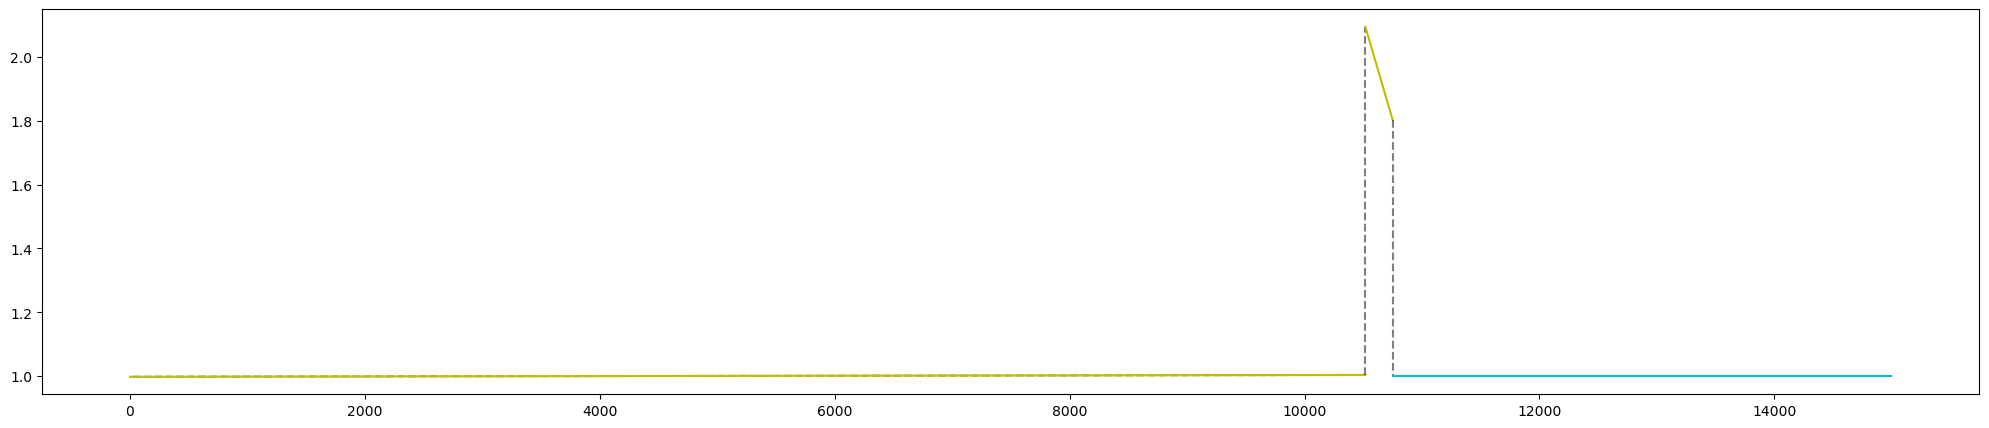

(0.999399839957322, 0.978448275862069, 0.9826839826839827, 0.980561555075594)

In [62]:
max_error = 10
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,"Sliding Window with regression 0.3")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_sldw,pre_sldw,recall_sldw,f1_sldw

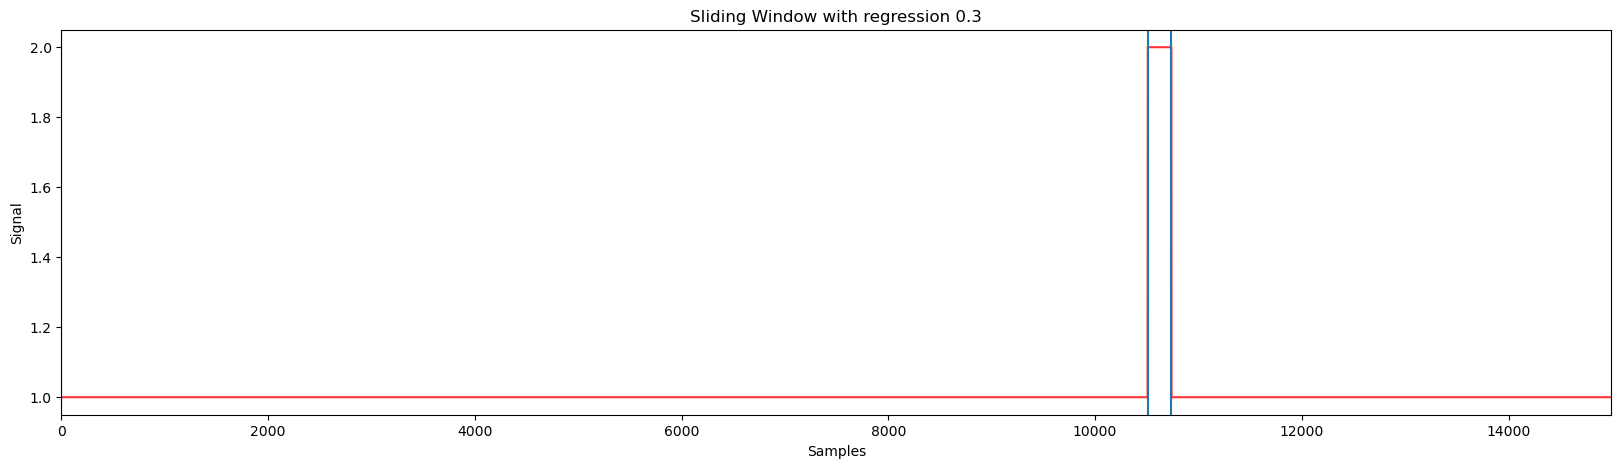

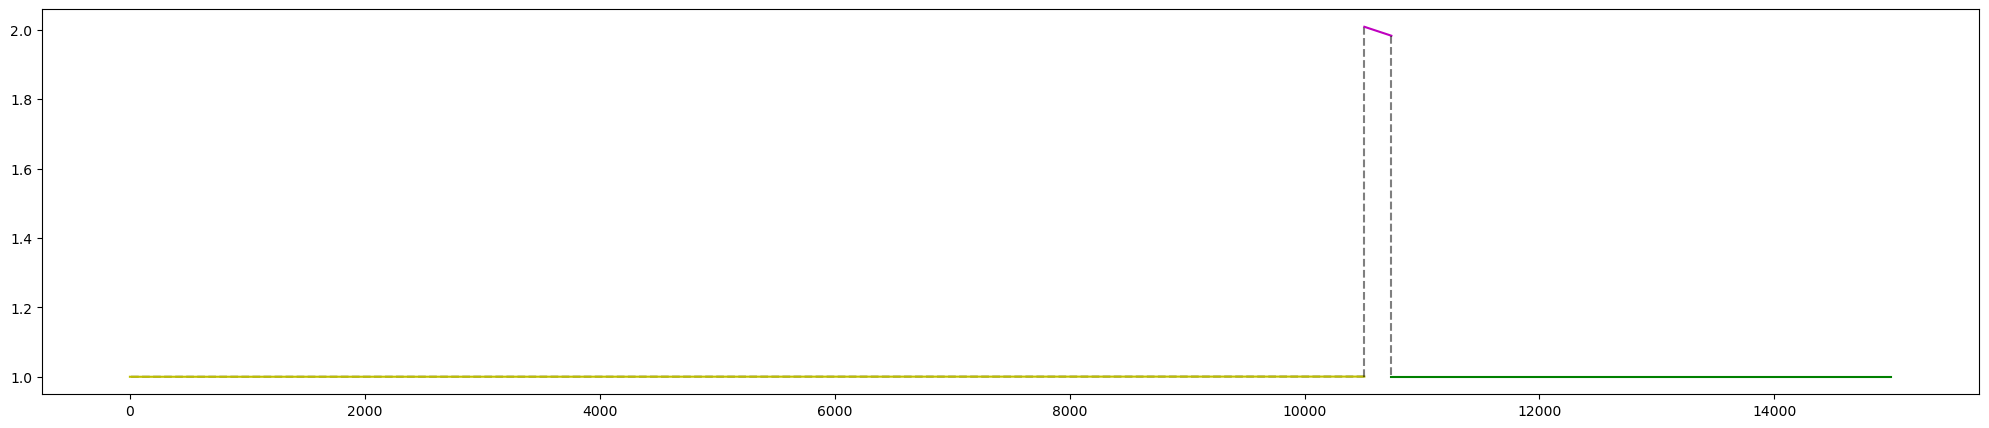

(0.998066150973593, 0.9391304347826087, 0.935064935064935, 0.9370932754880694)

In [57]:
max_error = 1
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,"Sliding Window with regression 0.3")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_sldw,pre_sldw,recall_sldw,f1_sldw

# SWAB

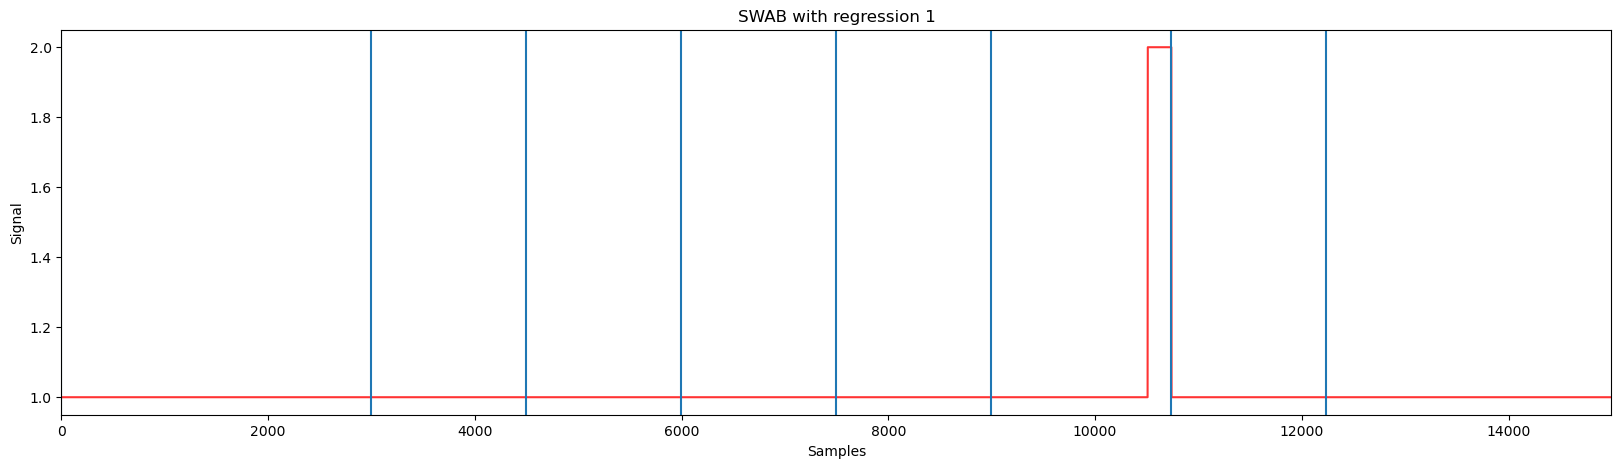

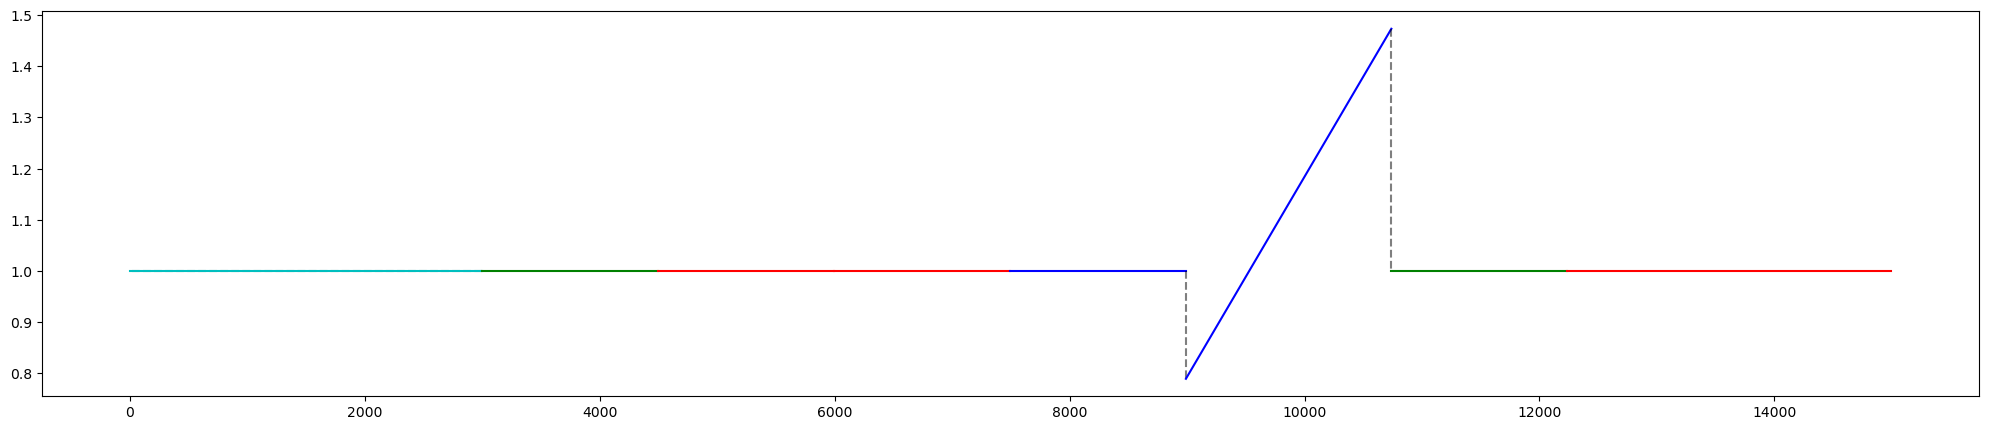

(0.8867031208322219,
 0.010013351134846462,
 0.06493506493506493,
 0.01735106998264893)

In [74]:
max_error = 1
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_swab,pre_swab,recall_swab,f1_swab

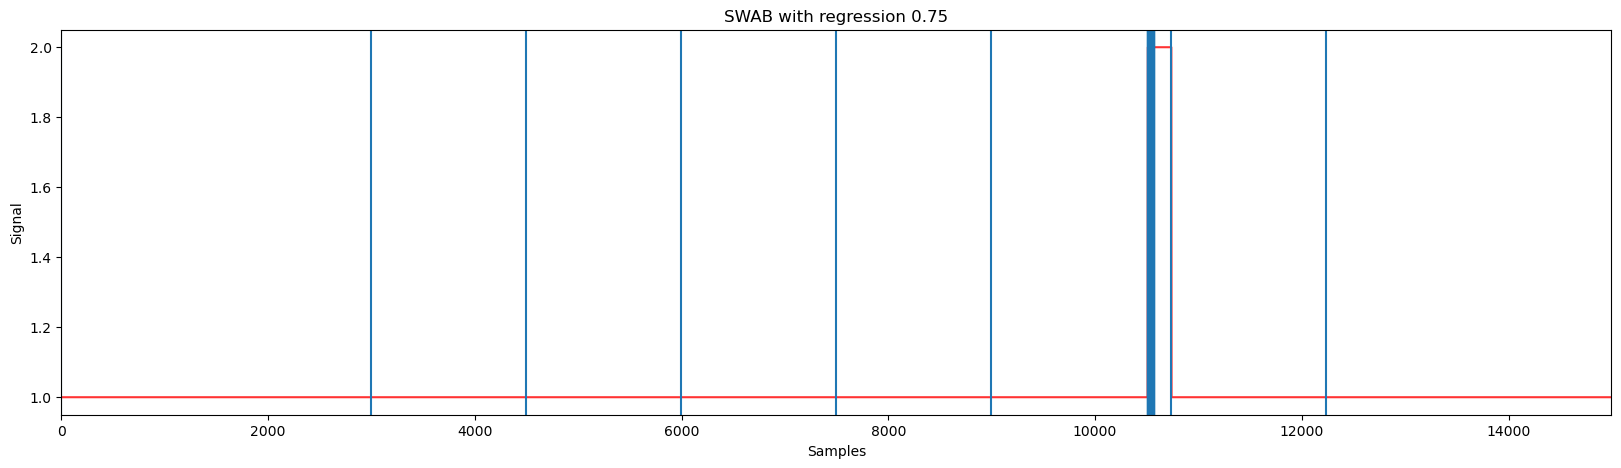

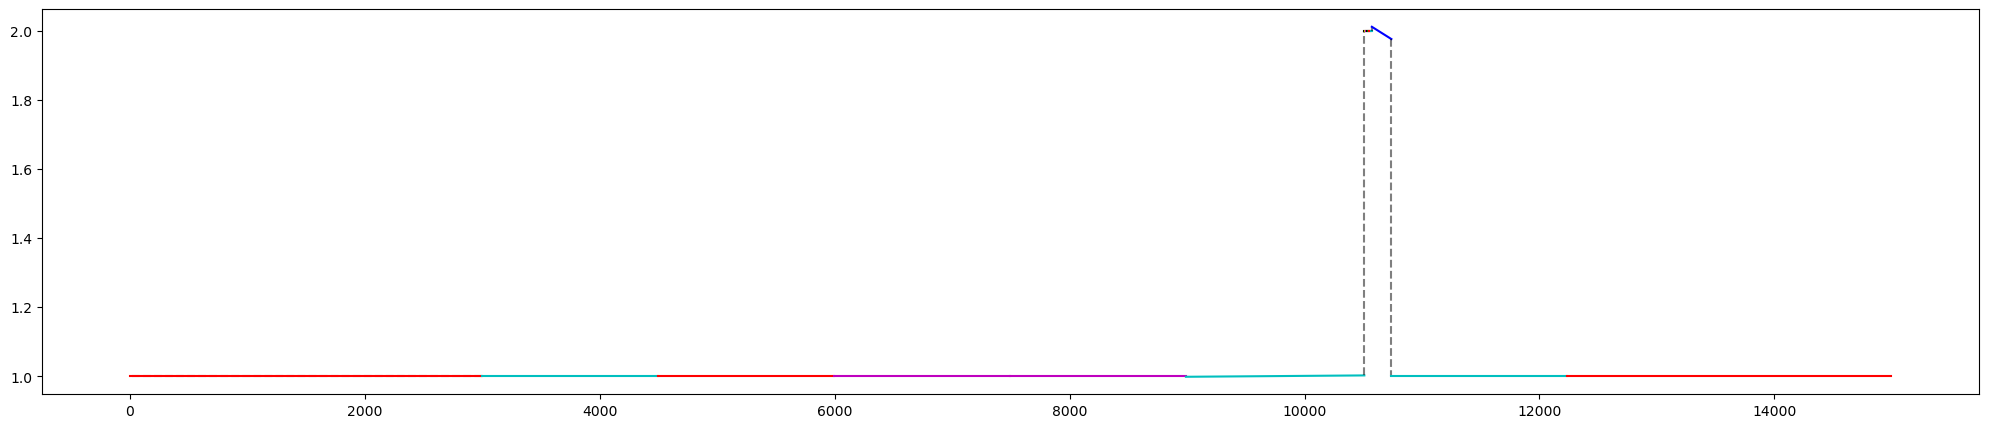

(0.883302213923713, 0.0, 0.0, 0)

In [73]:
max_error = 0.75
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_swab,pre_swab,recall_swab,f1_swab

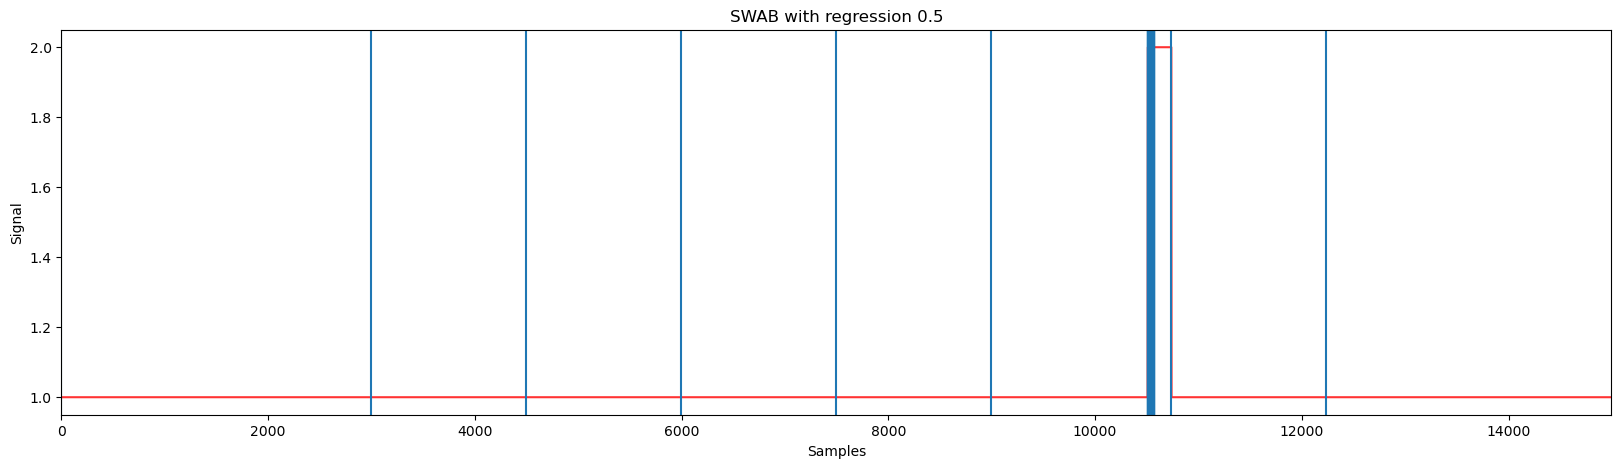

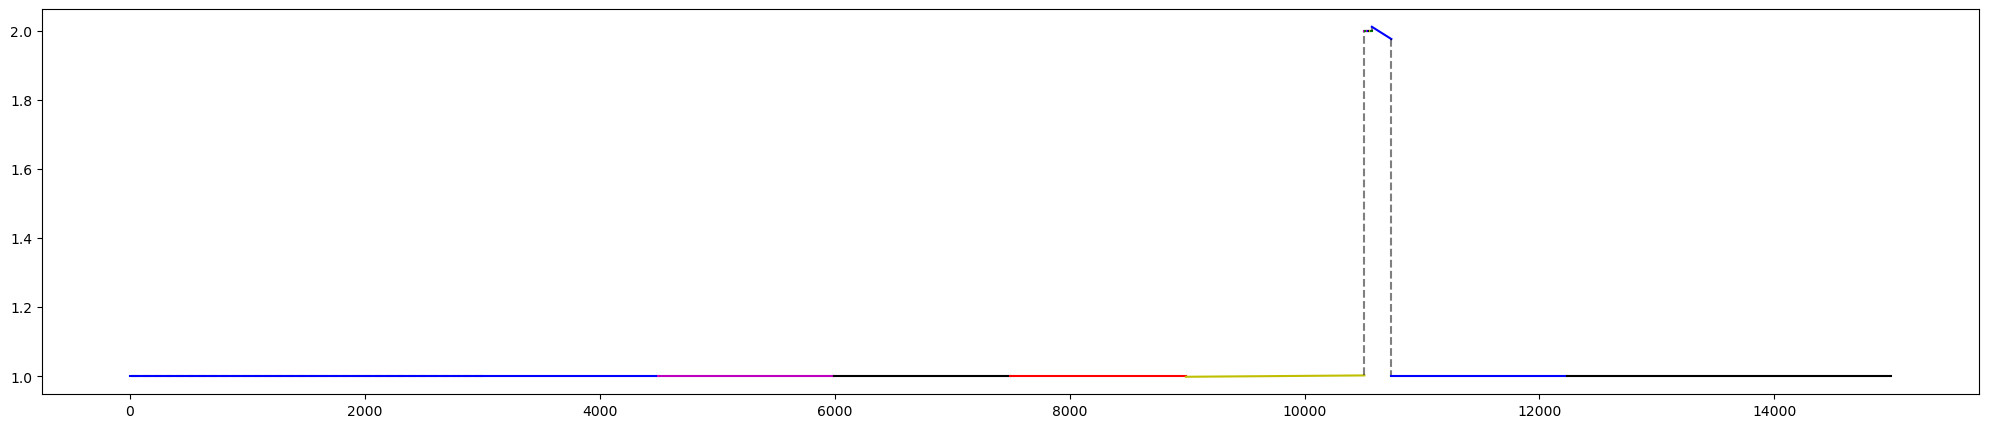

(0.883302213923713, 0.0, 0.0, 0)

In [72]:
max_error = 0.5
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_swab,pre_swab,recall_swab,f1_swab

# Conclusion

In [93]:
range_Top_down = [1,200]
range_Bottom_up = [0.1,1]
range_sliding_window = [0.5,30]
range_swab = [0.1,1]


time_avg_Top_down = (22.8+23+21.9)/3
time_avg_Bottom_up = (5.91+5.75+5.80)/3
time_avg_sliding_window = (6.04+5.95+6.66)/3
time_avg_swab = (48.1+48.4+6.59)/3


best_Top_down = 100
best_Bottom_up = 0.5
best_sliding_window = 10
best_swab =  0.5


In [94]:
data = {
    'Id' : ['P601 Status','P601 Status','P601 Status','P601 Status'],
    'Algorithm': ['Top-down', 'Bottom-up', 'Sliding-window','SWAB'],
    'min': [range_Top_down[0],range_Bottom_up[0], range_sliding_window[0],range_swab[0]],
    'max': [range_Top_down[1],range_Bottom_up[1],range_sliding_window[1],range_swab[1]],
    'Best': [best_Top_down, best_Bottom_up,best_sliding_window,best_swab],
    'Time Average(s)': [time_avg_Top_down, time_avg_Bottom_up, time_avg_sliding_window,time_avg_swab],
    'Accuracy' : [acc_topdown,acc_btu,acc_sldw,acc_swab],
    'Precision' : [pre_topdown,pre_btu,pre_sldw,pre_swab],
    'Recall' : [recall_topdown,recall_btu,recall_sldw,recall_swab],
    'F1-score' : [f1_topdown,f1_btu,f1_sldw,f1_swab],
    'Rank' : [2,4,1,3]
}

conclusion_df = pd.DataFrame(data)
conclusion_df

,Id,Algorithm,min,max,Best,Time Average(s),Accuracy,Precision,Recall,F1-score,Rank
0,P601 Status,Top-down,1.0,200,100.0,22.566667,0.997933,0.934783,0.930736,0.932755,2
1,P601 Status,Bottom-up,0.1,1,0.5,5.820000,0.462723,0.000000,0.000000,0.000000,4
2,P601 Status,Sliding-window,0.5,30,10.0,6.216667,0.999400,0.978448,0.982684,0.980562,1
3,P601 Status,SWAB,0.1,1,0.5,34.363333,0.886703,0.010013,0.064935,0.017351,3


In [95]:
old_conclusion_df = pd.read_csv('exp\SWat2019\Conclusion.csv')
add_df = conclusion_df.drop(columns='Rank')
conclusion_df = pd.concat([old_conclusion_df, add_df], ignore_index=True)
conclusion_df = conclusion_df.drop_duplicates()
conclusion_df.to_csv('exp\SWat2019\Conclusion.csv',index=False)

 # Feature max erorr

In [97]:
num_datapoints = np.shape(SWaT_2019_df)[0]

In [98]:
feature_max_error = pd.DataFrame(data=extracted_relevant_feature.T)
feature_max_error['id'] = 'P301 Status'
feature_max_error['Num_points'] = num_datapoints
feature_max_error['Min(max_error)_Top_down'] = range_Top_down[0]
feature_max_error['Max(max_error)_Top_down'] = range_Top_down[1]
feature_max_error['Min(max_error)_Bottom_up'] = range_Bottom_up[0]
feature_max_error['Max(max_error)_Bottom_up'] = range_Bottom_up[1]
feature_max_error['Min(max_error)_SLDW'] = range_sliding_window[0]
feature_max_error['Max(max_error)_SLDW'] = range_sliding_window[1]
feature_max_error['Min(max_error)_SWAB'] = 0.1
feature_max_error['Max(max_error)_SWAB'] = 700
feature_max_error['Best(max_error)_SWAB'] = best_Top_down
feature_max_error['Best(max_error)_SWAB'] = best_Bottom_up
feature_max_error['Best(max_error)_SWAB'] = best_sliding_window
feature_max_error['Best(max_error)_SWAB'] = 500

numpoints_column = feature_max_error.pop('Num_points')
feature_max_error.insert(0, 'Num_points', numpoints_column)
id_column = feature_max_error.pop('id')
feature_max_error.insert(0, 'id', id_column)

In [99]:
old_feat_df = pd.read_csv('exp\SWat2019\Feature__Maxerror.csv')
add_feat_df = feature_max_error
feat_df = pd.concat([old_feat_df, add_feat_df], ignore_index=True)
feat_df = feat_df.drop_duplicates()
feat_df.to_csv('exp\SWat2019\Feature__Maxerror.csv',index=False)
feat_df

,id,Num_points,mean,median,variance,standard_deviation,mean_change,kurtosis,minimum,maximum,Min(max_error)_Top_down,Max(max_error)_Top_down,Min(max_error)_Bottom_up,Max(max_error)_Bottom_up,Min(max_error)_SLDW,Max(max_error)_SLDW,Min(max_error)_SWAB,Max(max_error)_SWAB,Best(max_error)_SWAB
0,LIT 301,14996,946.637019,981.1587,8494.478007,92.165492,0.010217,-1.072911,730.7021,1112.77563,100000,500000,0.10,700.0,20000.0,200000,0.1,700,500
1,MV 501,14996,1.988530,2.0000,0.013205,0.114914,0.000000,133.339292,0.0000,2.00000,20,100,1.00,5.0,10.0,40,0.1,700,500
2,MV201,14996,1.369765,1.0000,0.244909,0.494883,0.000000,-1.470841,0.0000,2.00000,100,3000,4.00,5.0,215.0,300,0.1,700,500
3,MV 501,14996,1.374166,1.0000,0.234166,0.483907,0.000000,-1.729700,1.0000,2.00000,100,2000,1.00,55.0,1.0,15,0.1,700,500
4,P301 Status,14996,1.477527,1.0000,0.249495,0.499495,0.000067,-1.992167,1.0000,2.00000,20,75,0.05,0.1,1.0,40,0.1,700,500
5,P301 Status,14996,1.015337,1.0000,0.015102,0.122891,0.000000,60.236059,1.0000,2.00000,1,200,0.10,1.0,0.5,30,0.1,700,500
